In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, RepeatedKFold
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [106]:
df_train=pd.read_csv("E:\\jinnan\\train_dispersion.csv")
df_train=df_train[df_train['yield_rate']>0.87]
df_train.drop(['B3', 'B13', 'A13', 'A18', 'A23'], axis=1, inplace=True)
for col in df_train.columns:
    rate = df_train[col].value_counts(normalize=True, dropna=False).values[0]
    if rate > 0.9:
        df_train.drop(columns=[col], axis=1, inplace=True)
binary_label_array=np.zeros(df_train.shape[0])
binary_label_array[df_train["yield_rate"]>0.93]=1
label_array=df_train["yield_rate"].values
df_train["id"]=df_train['id'].apply(lambda x: int(x[7:]))
df_train.drop(columns=['yield_rate'],axis=1,inplace=True)
print('train1:',df_train.shape)
df_train2=pd.read_csv("E:\\jinnan\\train_binning_mean.csv")
print('train2:',df_train2.shape)
df_train.index=range(df_train.shape[0])
df_train2.index=range(df_train2.shape[0])
df_train=pd.concat([df_train,df_train2],axis=1)
train_array=df_train.values
print(df_train.columns,df_train.shape)

# df_test=pd.read_csv("E:\\jinnan\\test_after_clean.csv")
df_test=pd.read_csv("E:\\jinnan\\test_dispersion.csv")
df_test.drop(['B3', 'B13', 'A13', 'A18', 'A23'], axis=1, inplace=True)
for col in df_test.columns:
    rate = df_test[col].value_counts(normalize=True, dropna=False).values[0]
    if rate > 0.9:
        df_test.drop(columns=[col], axis=1, inplace=True)
columns_list=list(df_test.columns)
# columns_list.remove("id")
sample_id=df_test["id"]
df_test["id"]=df_test['id'].apply(lambda x: int(x[7:]))

df_test2=pd.read_csv("E:\\jinnan\\testA_binning_mean.csv")
df_test=pd.concat([df_test,df_test2],axis=1)
test_array=df_test.values
print(df_test.columns,df_test.shape)

train1: (1381, 78)
train2: (1381, 105)
Index(['A10', 'A11', 'A12', 'A14', 'A15', 'A16', 'A17', 'A19', 'A20',
       'A20range',
       ...
       'B14_to_B11_intTarget_0.0_mean', 'B14_to_B11_intTarget_1.0_mean',
       'B14_to_B11_intTarget_2.0_mean', 'B14_to_B11_intTarget_3.0_mean',
       'B14_to_B11_intTarget_4.0_mean', 'B14_to_B14_intTarget_0.0_mean',
       'B14_to_B14_intTarget_1.0_mean', 'B14_to_B14_intTarget_2.0_mean',
       'B14_to_B14_intTarget_3.0_mean', 'B14_to_B14_intTarget_4.0_mean'],
      dtype='object', length=183) (1381, 183)
Index(['A10', 'A11', 'A12', 'A14', 'A15', 'A16', 'A17', 'A19', 'A20',
       'A20range',
       ...
       'B14_to_B11_intTarget_0.0_mean', 'B14_to_B11_intTarget_1.0_mean',
       'B14_to_B11_intTarget_2.0_mean', 'B14_to_B11_intTarget_3.0_mean',
       'B14_to_B11_intTarget_4.0_mean', 'B14_to_B14_intTarget_0.0_mean',
       'B14_to_B14_intTarget_1.0_mean', 'B14_to_B14_intTarget_2.0_mean',
       'B14_to_B14_intTarget_3.0_mean', 'B14_to_B14_intTa

In [87]:
# (label_array.max()-label_array.min())/2+label_array.min()
print(train_array.shape,binary_label_array.shape)

(1381, 183) (1381,)


In [107]:
xgb_params = {'eta': 0.005, 'max_depth': 10, 'subsample': 0.8, 'colsample_bytree': 0.8,
          'objective': 'binary:logistic', 'eval_metric': 'error', 'silent': True, 'nthread': 4}
folds = KFold(n_splits=5, shuffle=True, random_state=2018)
oof_xgb = np.zeros(len(df_train))
predictions_xgb = np.zeros(len(df_test))
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_array, binary_label_array)):
    print("fold n°{}".format(fold_ + 1))
    trn_data = xgb.DMatrix(train_array[trn_idx], binary_label_array[trn_idx])
    val_data = xgb.DMatrix(train_array[val_idx], binary_label_array[val_idx])

    watchlist = [(trn_data, 'train'), (val_data, 'valid_data')]
    clf = xgb.train(dtrain=trn_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200,
                    verbose_eval=100, params=xgb_params)
    oof_xgb[val_idx] = clf.predict(xgb.DMatrix(train_array[val_idx]), ntree_limit=clf.best_ntree_limit)
    predictions_xgb += clf.predict(xgb.DMatrix(test_array), ntree_limit=clf.best_ntree_limit) / folds.n_splits
    
# print("CV score: {:<8.8f}".format(mean_squared_error(oof_xgb, label_array)))

fold n°1
[0]	train-error:0.112319	valid_data-error:0.180505
Multiple eval metrics have been passed: 'valid_data-error' will be used for early stopping.

Will train until valid_data-error hasn't improved in 200 rounds.
[100]	train-error:0.080616	valid_data-error:0.115523
[200]	train-error:0.074275	valid_data-error:0.119134
Stopping. Best iteration:
[51]	train-error:0.089674	valid_data-error:0.108303

fold n°2
[0]	train-error:0.107692	valid_data-error:0.152174
Multiple eval metrics have been passed: 'valid_data-error' will be used for early stopping.

Will train until valid_data-error hasn't improved in 200 rounds.
[100]	train-error:0.081448	valid_data-error:0.108696
[200]	train-error:0.072398	valid_data-error:0.108696
Stopping. Best iteration:
[16]	train-error:0.087783	valid_data-error:0.101449

fold n°3
[0]	train-error:0.096833	valid_data-error:0.195652
Multiple eval metrics have been passed: 'valid_data-error' will be used for early stopping.

Will train until valid_data-error hasn't 

In [57]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,accuracy_score

def plt_plot(y_real):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(range(len(y_real)),y_real, color='b')
    plt.show()
def plt_plot_2(y_real,y_predicted):
    fig = plt.figure(figsize=(16,12))
    ax = fig.add_subplot(1, 1, 1)
    ax.bar(range(len(y_real)),y_real, color='r',)
    ax.plot(range(len(y_predicted)),y_predicted, color='b')
    plt.ylim(0.85,1.01)
    plt.show()

In [108]:
train_result=np.zeros(oof_xgb.shape[0])
train_result[oof_xgb>=0.5]=1
train_result[oof_xgb<0.5]=0
# for temp in oof_xgb:
#     print(temp)
print(np.sum(train_result))
print(np.sum(binary_label_array))
print(accuracy_score(binary_label_array, train_result, normalize=True, sample_weight=None))
print(confusion_matrix(binary_label_array, train_result, labels=None, sample_weight=None))

476.0
511.0
0.8747284576393918
[[801  69]
 [104 407]]


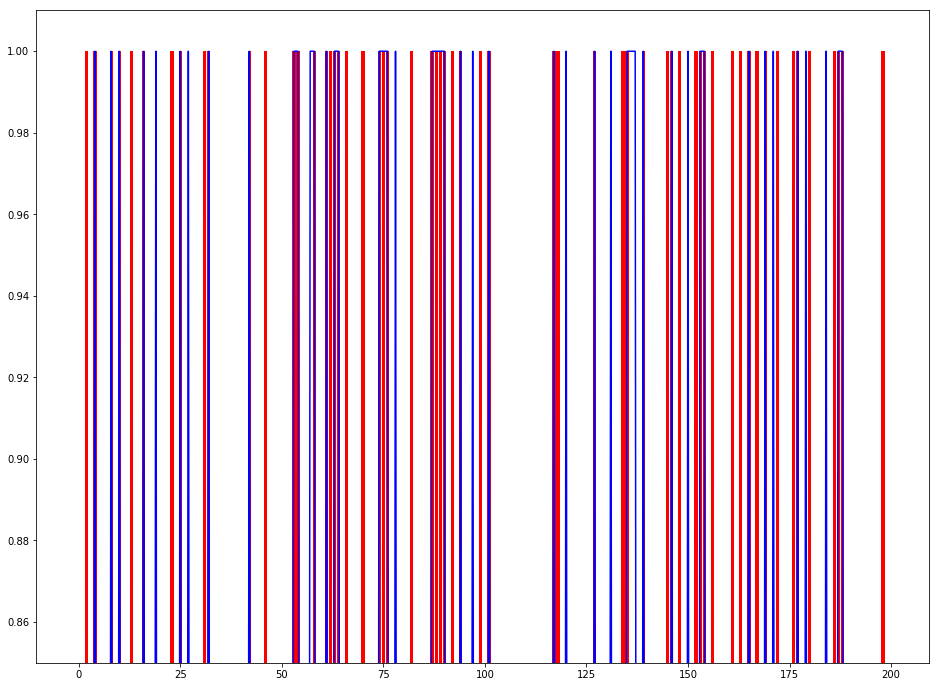

In [44]:
plt_plot_2(binary_label_array[0:200],oof_xgb[0:200])
# plt_plot_2(binary_label_array[200:400],oof_xgb[200:400])
# plt_plot_2(binary_label_array[400:600],oof_xgb[400:600])
# plt_plot_2(binary_label_array[600:800],oof_xgb[600:800])
# plt_plot_2(binary_label_array[800:1000],oof_xgb[800:1000])
# plt_plot_2(binary_label_array[1000:1200],oof_xgb[1000:1200])
# plt_plot_2(binary_label_array[1200:],oof_xgb[1200:])

In [109]:
predicted_result=np.zeros(predictions_xgb.shape[0])
predicted_result[predictions_xgb>=0.5]=1
df_binary_predi=pd.DataFrame(predicted_result,columns=['bin'])
df_binary_predi.to_csv("E:\\jinnan\\binary.csv",index=False)